In [ ]:
# default_exp core

# fastproaudio core

> API details.

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastai librosa torchaudio pyzenodo3 # for colab testing

In [ ]:
#export

#from fastai.vision.all import *
from fastai.data.all import *
#from subprocess import Popen, PIPE
import pyzenodo3
import torchaudio
import librosa
import librosa.display
from IPython.display import Audio 
import re

#from zipfile import ZipFile

# some data urls
URLs.AUDIOMDPI = 'https://zenodo.org/record/3562442'
URLs.MARCO = URLs.AUDIOMDPI  # just a shorthand alias I'm more likely to remember
URLs.SIGNALTRAIN_LA2A_1_1 = 'https://zenodo.org/record/3824876'
URLs.SIGNALTRAIN_LA2A_REDUCED = 'http://hedges.belmont.edu/data/SignalTrain_LA2A_Reduced.tgz'

Some audio data urls: 

URLs.AUDIOMDPI = 'https://zenodo.org/record/3562442'

URLs.MARCO = URLs.AUDIOMDPI  # just a shorthand alias I'm more likely to remember

URLs.SIGNALTRAIN_LA2A_1_1 = 'https://zenodo.org/record/3824876'

URLs.SIGNALTRAIN_LA2A_REDUCED = 'http://hedges.belmont.edu/data/SignalTrain_LA2A_Reduced.tgz'

In [ ]:
#export
def zenodo_url_to_data_url(url):
    #%pip install pyzenodo3 -q
    zen = pyzenodo3.Zenodo()
    record = url.split('/')[-1]
    return zen.get_record(record).data['files'][0]['links']['self']  

In [ ]:
#slow
print(URLs.MARCO)
print(zenodo_url_to_data_url(URLs.MARCO))

https://zenodo.org/record/3562442
https://zenodo.org/api/files/d6589bb4-d6a6-4bc6-8e51-e6334fafbe3f/AudioMDPI.zip


In [ ]:
#slow
print(URLs.SIGNALTRAIN_LA2A_1_1)
print(zenodo_url_to_data_url(URLs.SIGNALTRAIN_LA2A_1_1))

https://zenodo.org/record/3824876
https://zenodo.org/api/files/df302f12-7355-452e-93d1-b0c9344608f7/SignalTrain_LA2A_Dataset_1.1.tgz


In [ ]:
#export 

# extract_func no longer supported  in untar_data, so zipfile stuff is unused
# thanks KevinB for the zip_extract! https://forums.fast.ai/t/generalizing-untar-data-to-also-work-with-zips/53741/14?u=drscotthawley
#def zip_extract(fname, dest):
#    zipfile.ZipFile(fname, mode='r').extractall(dest)

def get_audio_data(url):
    if ('zenodo' in url.lower()):
        url = zenodo_url_to_data_url(url)
    if '.zip' in url[-5:]:
        return untar_data(url)#, extract_func=zip_extract) #
    else:
        return untar_data(url) 

Try downloading a sample .tgz file

In [ ]:
#slow
path_st = get_audio_data(URLs.SIGNALTRAIN_LA2A_REDUCED)
path_st

Path('/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced')

And try downloading from a Zenodo URL:

In [ ]:
#slow
path_audiomdpi = get_audio_data(URLs.MARCO)
path_audiomdpi

Path('/home/shawley/.fastai/data/AudioMDPI')

In [ ]:
#all_slow

Let's use this data as an example and take a look at it:

In [ ]:
path_audiomdpi.ls()

(#4) [Path('/home/shawley/.fastai/data/AudioMDPI/LeslieWoofer'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn'),Path('/home/shawley/.fastai/data/AudioMDPI/license.txt'),Path('/home/shawley/.fastai/data/AudioMDPI/6176ChannelStrip')]

We'll grab the `LeslieHorn` subset

In [ ]:
horn = path_audiomdpi / "LeslieHorn"; horn.ls()

(#4) [Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/readme.txt'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/chorale'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/tremolo'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/dry')]

In [ ]:
path_dry = horn /'dry'
#path_trem = horn / 'tremolo'
audio_extensions = ['.m3u', '.ram', '.au', '.snd', '.mp3','.wav']
fnames_dry = get_files(path_dry, extensions=audio_extensions)

In [ ]:
waveform, sample_rate = torchaudio.load(fnames_dry[0])

Let's take a look at it:

In [ ]:
#export 

def show_info(waveform, sample_rate):
    print(f"Shape: {tuple(waveform.shape)}, Dtype: {waveform.dtype}, Duration: {waveform.shape[-1]/sample_rate} s")
    print(f"Max: {waveform.max().item():6.3f},  Min: {waveform.min().item():6.3f}, Mean: {waveform.mean().item():6.3f}, Std Dev: {waveform.std().item():6.3f}")

def plot_waveform(
    waveform,       # the tensor to plot.
    sample_rate,    # used for labeling x-axis in terms of time
    ax=None,        # can be an existing array of plot axes, or None
    xlim=None,      # limits of x-axis
    ylim=[-1,1],    # limits of y-axis
    color = 'blue',      # can specify color for waveform plot 
    label = '',     # label for waveform plot
    title= 'Waveform'):      
    "Waveform plot, from https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html"
    if ax is None: fig, ax = plt.subplots()
    waveform = waveform.numpy()
    if len(waveform.shape) < 2:  waveform =  waveform[np.newaxis, :]
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    if num_channels > 1:
        for c in range(num_channels):
            label = f'Channel {c+1}' if num_channels > 1 else ''  # overwrite label kwarg
            ax.plot(time_axis, waveform[c], linewidth=1, label=label)
    else:
        ax.plot(time_axis, waveform[0], linewidth=1, color=color, label=label)
    ax.grid(True)
    if ylim: ax.set_ylim(ylim)
    ax.title.set_text(title)
    ax.set_xlabel('Time (s)')
    if num_channels > 1: ax.legend()
    if ax is None: plt.show(block=False)

def plot_melspec(waveform, sample_rate, ax=None, ref=np.max, vmin=-70, vmax=0):
    "Mel-spectrogram plot, from librosa documentation"
    if ax is None: fig, ax = plt.subplots()
    M = librosa.feature.melspectrogram(y=waveform.numpy()[0], sr=sample_rate)
    M_db = librosa.power_to_db(M, ref=ref)
    img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax, sr=sample_rate, vmin=vmin, vmax=vmax)
    ax.set(title='Mel spectrogram display (Channel 0)')
    plt.colorbar(img, ax=ax, format="%+2.f dB")
    if ax is None: plt.show(block=False)

def play_audio(waveform, sample_rate):
    """From torchaudio preprocessing tutorial.
    note ipython docs claim Audio can already do multichannel: "# Can also do stereo or more channels"
    """
    display(Audio(waveform.numpy(), rate=sample_rate, normalize=False))

        
def show_audio(waveform, sample_rate, info=True, play=True, plots=['waveform','melspec'], ref=500):
    "This display routine is an amalgam of the torchaudio tutorial and the librosa documentation:"
    # ref=500 is a bit arbitrary choice of reference intensity value but works well
    if info: show_info(waveform, sample_rate)
    if play: play_audio(waveform, sample_rate)
    num_channels = waveform.shape[0]
    if num_channels <= 2:
        ncols = len(plots)
        if  ncols > 0:
            fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12,4))  
            for i, pstr in enumerate(plots):
                if 'waveform'==pstr: plot_waveform(waveform, sample_rate, ax=ax[i] if ncols>1 else ax)
                if 'melspec'==pstr:  plot_melspec(waveform,  sample_rate, ax=ax[i] if ncols>1 else ax, ref=ref) 
    else:  # "multichannel audio" handled separately for backwards compatibility & needs of time-align project
        fig, ax = plt.subplots(nrows=num_channels, ncols=1, figsize=(10,2*num_channels)) # just plot waveforms for now
        for c in range(num_channels):
            plot_waveform(waveform[c], sample_rate, ax=ax[c], title='', color=(['k','b','y','g','r']*10)[c], label=f"Channel {c}")

Shape: (1, 110250), Dtype: torch.float32, Duration: 2.5 s
Max:  1.000,  Min: -0.973, Mean: -0.000, Std Dev:  0.086


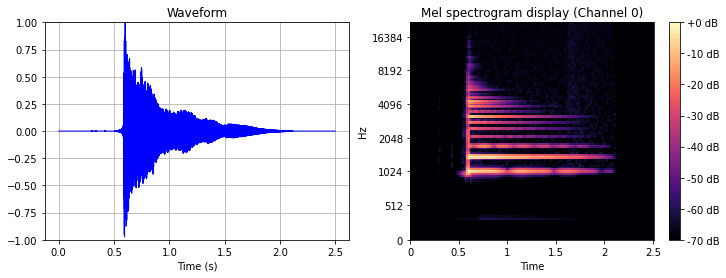

In [ ]:
#slow
show_audio(waveform, sample_rate)

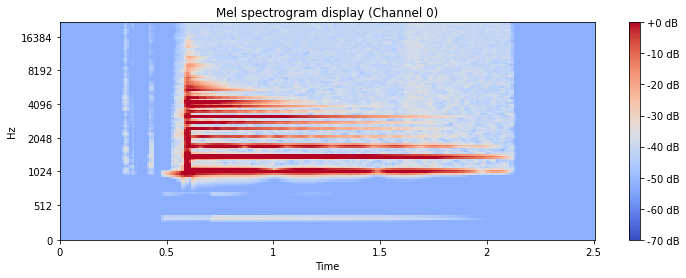

In [ ]:
#slow
show_audio(waveform, sample_rate, info=False, play=False, plots=['melspec'], ref=1)

## Multichannel Concerns:
Let's make a multi-channel tensor and "show" it:

In [ ]:
num_channels = 5
n = waveform.shape[-1]*3
waveform2 = torch.zeros((num_channels,n))
for c in range(num_channels):
    start = int(np.random.rand()*waveform.shape[-1]*(2))
    this_waveform, _ = torchaudio.load(fnames_dry[c])
    waveform2[c, start:start+waveform.shape[-1]] = this_waveform

Shape: (5, 330750), Dtype: torch.float32, Duration: 7.5 s
Max:  1.000,  Min: -1.000, Mean: -0.000, Std Dev:  0.037


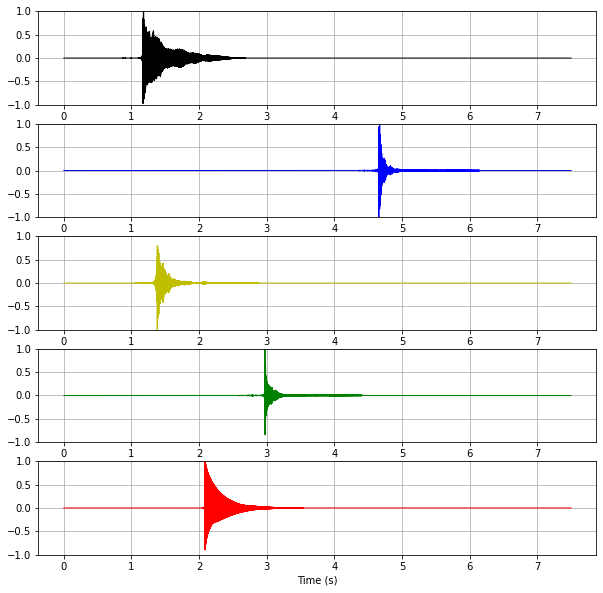

In [ ]:
show_audio(waveform2, sample_rate)

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_td_demo.ipynb.
Converted index.ipynb.


### File handlers for multichannel files
e.g. converting between a multiple-mono-files representation (with individual tracks designated by "-(alphanumerics)" (aka "hyphen+stuff"):

In [ ]:
#export
def get_accompanying_tracks(
    fn,       # one filename  
    fn_list,  # list of all filenames 
    remove=False,  # remove these accompanying filenames from the main list.
    ):
    """"Given one filename, and a list of all filenames, return a list of that filename and 
    any files it 'goes with'
    """
    # make a copies of fn & fn_list with all hyphen+stuff removed. 
    basename = re.sub(r'-[a-zA-Z0-9]+','', fn) 
    basename_list = [re.sub(r'-[a-zA-Z0-9]+','', x) for x in fn_list]
    
    # get indices of all elements of basename_list matching basename, return original filenames
    accompanying = [fn_list[i] for i, x in enumerate(basename_list) if x == basename]
    if remove: 
        for x in accompanying: 
            if x != fn: fn_list.remove(x)  # don't remove the file we search on though
    return accompanying # note accompanying list includes original file too

Tests for that:

In [ ]:
fn_list = ['input_21-0_.wav', 'input_21-1_.wav', 'input_21-hey_.wav', 'input_22_.wav', 'input_23_.wav', 'input_23-toms_.wav', 'input_24-0_.wav', 'input_24-kick_.wav']
print(fn_list)
track = fn_list[1]
print("getting matching tracks for ",track)
tracks  = get_accompanying_tracks(fn_list[1], fn_list, remove=True)
print("Accompanying tracks are: ",tracks)
print("new list = ",fn_list) # should have the extra 21- tracks removed.

['input_21-0_.wav', 'input_21-1_.wav', 'input_21-hey_.wav', 'input_22_.wav', 'input_23_.wav', 'input_23-toms_.wav', 'input_24-0_.wav', 'input_24-kick_.wav']
getting matching tracks for  input_21-1_.wav
Accompanying tracks are:  ['input_21-0_.wav', 'input_21-1_.wav', 'input_21-hey_.wav']
new list =  ['input_21-1_.wav', 'input_22_.wav', 'input_23_.wav', 'input_23-toms_.wav', 'input_24-0_.wav', 'input_24-kick_.wav']
